## Лабораторная работа № 3

Работу выполнил: Козлов Евгений

### Required imports

In [1]:

import torch
import torchvision
import torchvision.transforms as transforms
from collections import defaultdict
from torch.utils.data.dataloader import default_collate
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil

Checking acceleration for model

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
torch.manual_seed(1337)
if device == "cuda:0":
    torch.cuda.manual_seed_all(1337)

## Data management

In [4]:
imagenet_classes = defaultdict(int)

with open("imagenet1000_clsidx_to_labels.txt") as fh:
    data = fh.readlines()
    i = 0
    for line in data:
        els = line.rstrip().split(":")
        if els[0][0] == "{":
            els[0] = els[0][1:]
            
        if els[1][-1] == "}":
            els[1] = els[1][:-1]
            
        if els[0][0] == " ":
            els[0] = els[0][1:]
        els[1] = els[1][2:]
        els[1] = els[1][:-2]        
        num = int(els[0])
        classes = els[1].split(",")
        imagenet_classes[num] = classes


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 50

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)),
)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)),
)

cifar10_classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

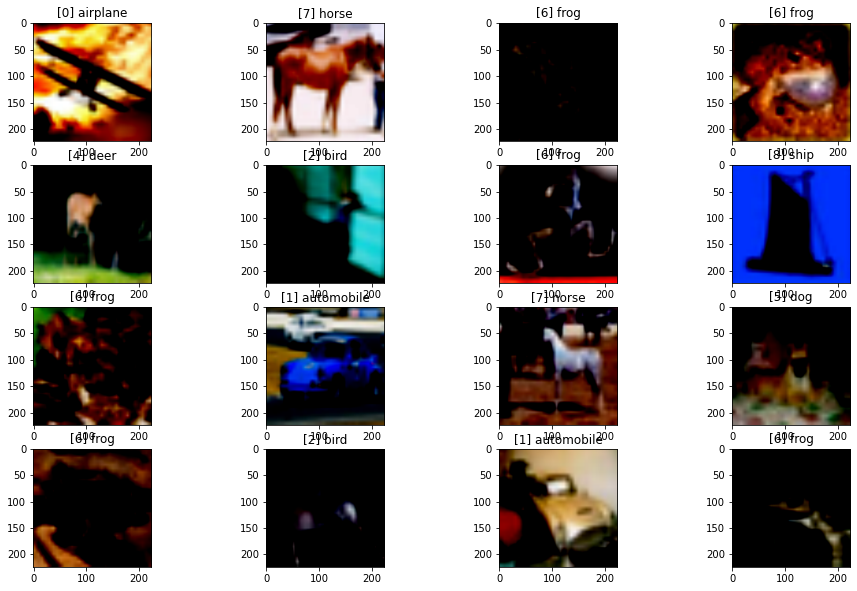

In [6]:
dataiter = iter(trainloader)

fig, ax = plt.subplots(4, 4, figsize=(16, 10))
gs = 4

for i in range(4):
    imb, lb = dataiter.next()
    l = lb.detach().tolist()
    for j in range(4):
        ax[i][j].imshow(imb[j].permute(1, 2, 0).detach().tolist());
        ax[i][j].set_title(f"[{l[j]}] {cifar10_classes[l[j]]}")
plt.show();

## AlexNet

In [7]:
alexnet = torchvision.models.alexnet(pretrained=True)
alexnet.eval().to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Исследуем скорость работы инференса модели и сколько она потратит памяти на свою работу

In [23]:
start_time = time.time()
memory_usage = []

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        outputs = alexnet(images)
        memory_usage.append(psutil.Process().memory_info().rss)
        
end_time = time.time()

inference_time = end_time - start_time  # Average inference time per image
average_memory_usage = sum(memory_usage) / len(memory_usage)  # Average memory consumption per iteration

print("Average Inference Time per Image:", inference_time, "seconds")
print("Average Memory Consumption per Iteration:", average_memory_usage / (1024 * 1024), "MB")

Average Inference Time per Image: 12.55754566192627 seconds
Average Memory Consumption per Iteration: 356.775859375 MB


Прогоняем один батч - 50 изображений через сеть

In [10]:
test = iter(testloader)
images, labels = test.next()

with torch.no_grad():
    yhat = alexnet(images)
    logits = torch.nn.functional.softmax(yhat, dim=1)
    predicted = torch.max(logits, dim=1)[1]


Смотрим какие предсказания выдает модель на каждую картинку.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


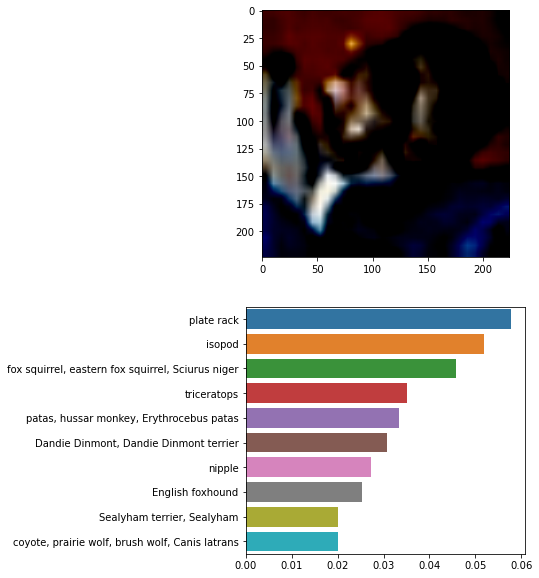

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


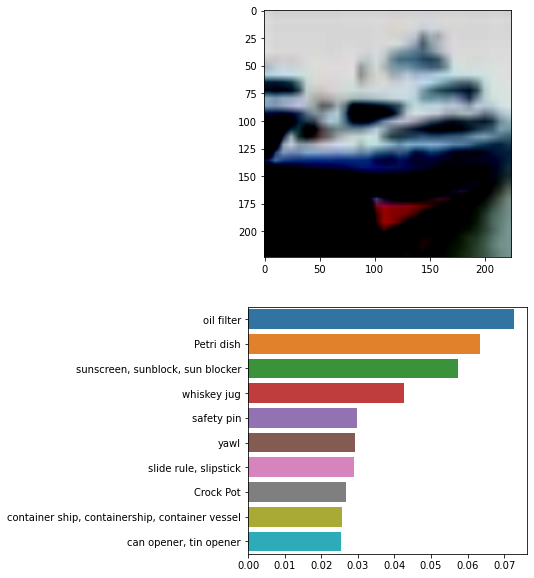

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


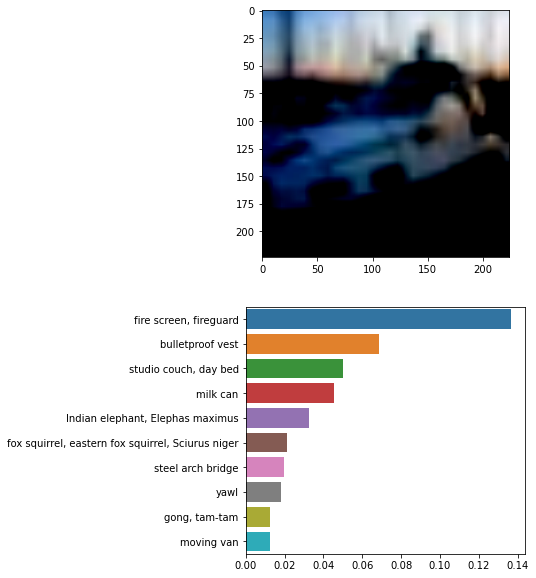

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


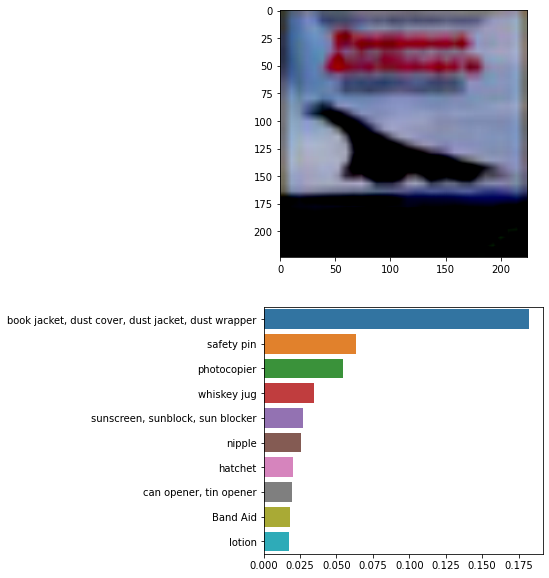

In [11]:
res = [imagenet_classes[c] for c in predicted.detach().tolist()]

for i in range(4):
    fig, ax = plt.subplots(2, 1, figsize=(5, 10))
    image = images[i].permute(1, 2, 0).detach().tolist()
    
    pred = torch.topk(logits[i], k=10)
    values = pred.values.detach().tolist()
    names = [imagenet_classes[c] for c in pred.indices.detach().tolist()]
    names = [",".join(name) for name in names]
    
    ax[0].imshow(image)
    sns.barplot(x=values, y=names, ax=ax[1])
    
    plt.show()

Осторожно, длинный вывод!


In [ ]:
res = [imagenet_classes[c] for c in predicted.detach().tolist()]

for i in range(50):
    fig, ax = plt.subplots(2, 1, figsize=(5, 10))
    image = images[i].permute(1, 2, 0).detach().tolist()
    
    pred = torch.topk(logits[i], k=10)
    values = pred.values.detach().tolist()
    names = [imagenet_classes[c] for c in pred.indices.detach().tolist()]
    names = [",".join(name) for name in names]
    
    ax[0].imshow(image)
    sns.barplot(x=values, y=names, ax=ax[1])
    
    plt.show()
    

## VGG16


In [67]:
vgg = torchvision.models.vgg16(pretrained=True)
vgg.eval().to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [68]:
start_time = time.time()
memory_usage = []

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        outputs = vgg(images)
        memory_usage.append(psutil.Process().memory_info().rss)
        
end_time = time.time()

inference_time = end_time - start_time  # Average inference time per image
average_memory_usage = sum(memory_usage) / len(memory_usage)  # Average memory consumption per iteration

print("Average Inference Time per Image:", inference_time, "seconds")
print("Average Memory Consumption per Iteration:", average_memory_usage / (1024 * 1024), "MB")

Average Inference Time per Image: 33.36986756324768 seconds
Average Memory Consumption per Iteration: 243.17759765625 MB


In [42]:
test = iter(testloader)
images, labels = test.next()

with torch.no_grad():
    yhat = vgg(images)
    logits = torch.nn.functional.softmax(yhat, dim=1)
    predicted = torch.max(logits, dim=1)[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


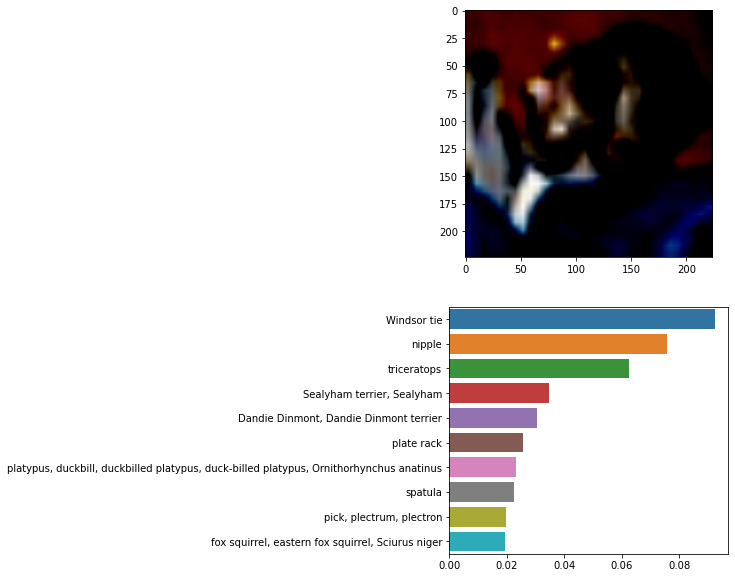

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


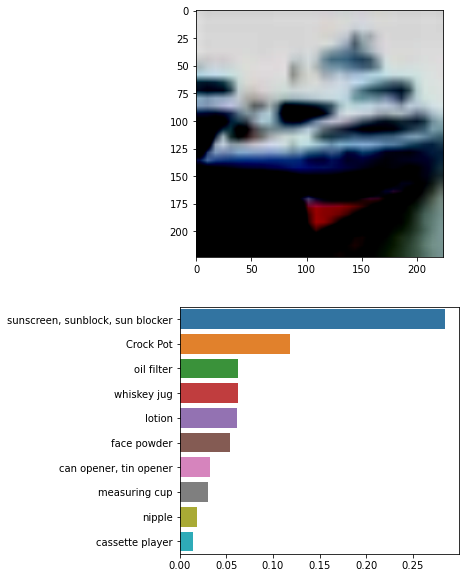

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


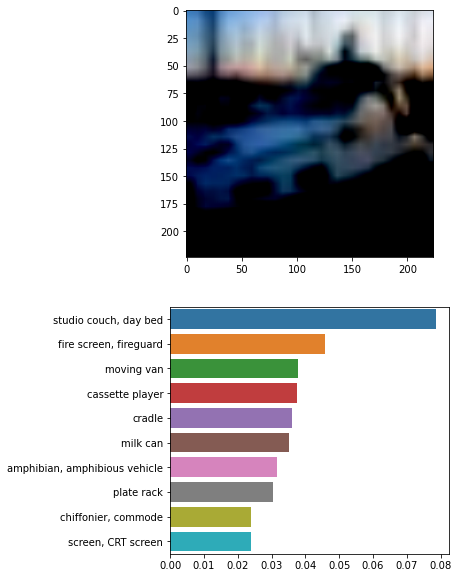

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


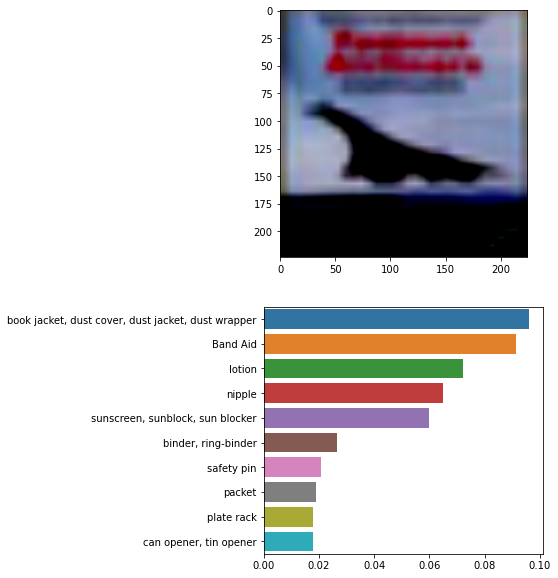

In [15]:
res = [imagenet_classes[c] for c in predicted.detach().tolist()]

for i in range(4):
    fig, ax = plt.subplots(2, 1, figsize=(5, 10))
    image = images[i].permute(1, 2, 0).detach().tolist()
    
    pred = torch.topk(logits[i], k=10)
    values = pred.values.detach().tolist()
    names = [imagenet_classes[c] for c in pred.indices.detach().tolist()]
    names = [",".join(name) for name in names]
    
    ax[0].imshow(image)
    sns.barplot(x=values, y=names, ax=ax[1])
    
    plt.show()

In [ ]:
res = [imagenet_classes[c] for c in predicted.detach().tolist()]

for i in range(50):
    fig, ax = plt.subplots(2, 1, figsize=(5, 10))
    image = images[i].permute(1, 2, 0).detach().tolist()
    
    pred = torch.topk(logits[i], k=10)
    values = pred.values.detach().tolist()
    names = [imagenet_classes[c] for c in pred.indices.detach().tolist()]
    names = [",".join(name) for name in names]
    
    ax[0].imshow(image)
    sns.barplot(x=values, y=names, ax=ax[1])
    
    plt.show()
    plt.savefig(f"vgg_preds/vgg_{i}.png")

## ResnNet50

In [47]:
resnet = torchvision.models.resnet50(pretrained=True)
resnet.eval().to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
start_time = time.time()
memory_usage = []

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        outputs = resnet(images)
        memory_usage.append(psutil.Process().memory_info().rss)
        
end_time = time.time()

inference_time = end_time - start_time  # Average inference time per image
average_memory_usage = sum(memory_usage) / len(memory_usage)  # Average memory consumption per iteration

print("Average Inference Time per Image:", inference_time, "seconds")
print("Average Memory Consumption per Iteration:", average_memory_usage / (1024 * 1024), "MB")

Average Inference Time per Image: 21.47453260421753 seconds
Average Memory Consumption per Iteration: 349.35625 MB


In [48]:
test = iter(testloader)
images, labels = test.next()

with torch.no_grad():
    yhat = vgg(images)
    logits = torch.nn.functional.softmax(yhat, dim=1)
    predicted = torch.max(logits, dim=1)[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


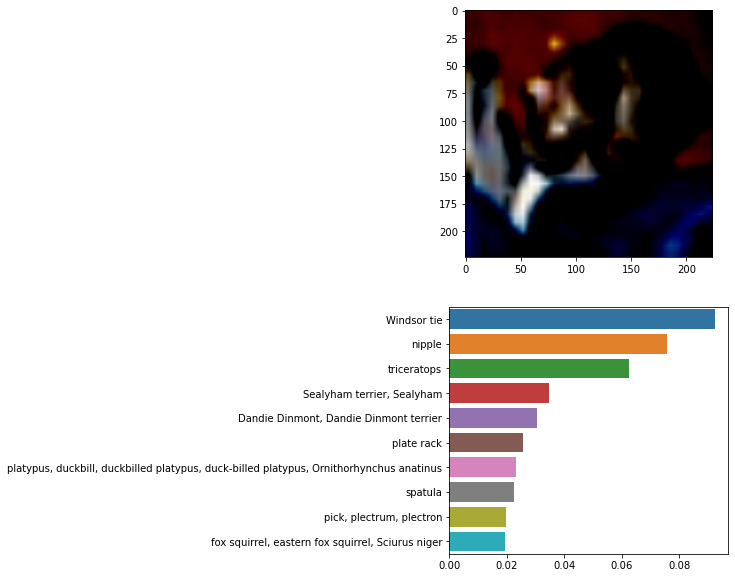

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


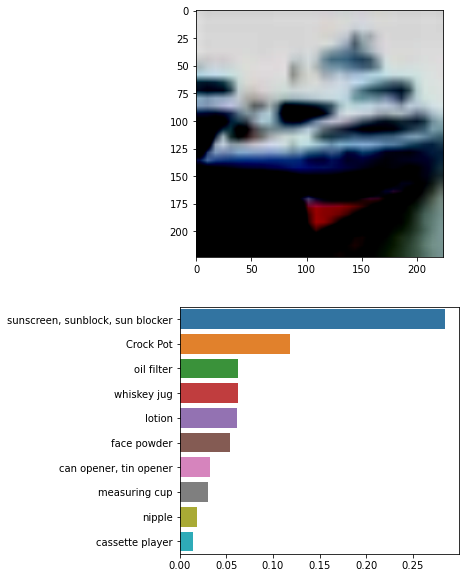

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


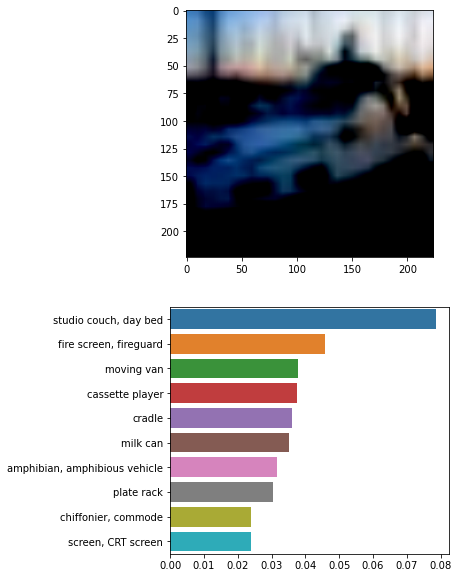

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


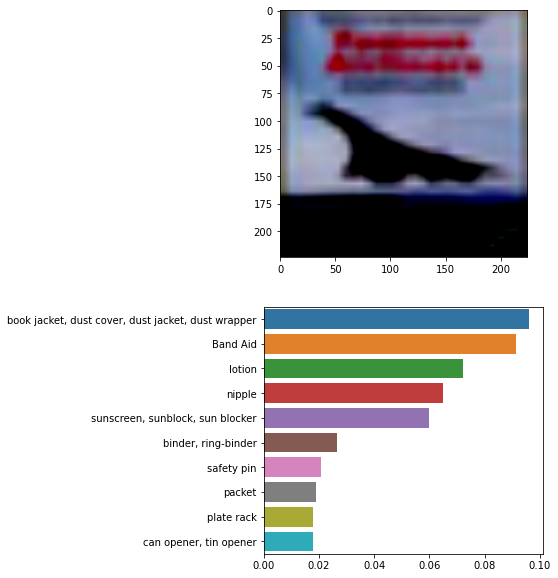

In [49]:
res = [imagenet_classes[c] for c in predicted.detach().tolist()]

for i in range(4):
    fig, ax = plt.subplots(2, 1, figsize=(5, 10))
    image = images[i].permute(1, 2, 0).detach().tolist()
    
    pred = torch.topk(logits[i], k=10)
    values = pred.values.detach().tolist()
    names = [imagenet_classes[c] for c in pred.indices.detach().tolist()]
    names = [",".join(name) for name in names]
    
    ax[0].imshow(image)
    sns.barplot(x=values, y=names, ax=ax[1])
    
    plt.show()

In [ ]:
res = [imagenet_classes[c] for c in predicted.detach().tolist()]

for i in range(50):
    fig, ax = plt.subplots(2, 1, figsize=(5, 10))
    image = images[i].permute(1, 2, 0).detach().tolist()
    
    pred = torch.topk(logits[i], k=10)
    values = pred.values.detach().tolist()
    names = [imagenet_classes[c] for c in pred.indices.detach().tolist()]
    names = [",".join(name) for name in names]
    
    ax[0].imshow(image)
    sns.barplot(x=values, y=names, ax=ax[1])
    
    plt.show()
    plt.savefig(f"resnet_preds/resnet_{i}.png")

## Some plots

In [56]:
import pandas as pd

In [58]:

data = {
    "speed" :[12.55754566192627, 37.93083214759827, 21.47453260421753],
    "memory": [356.775859375, 214.767109375, 349.35625],
    "top1_acc": [0.06, 0.3, 0.36],
    "top5_acc": [0.14, 0.52, 0.68],
}
m_names = ["AlexNet", "VGG16", "ResNe50"]

df = pd.DataFrame(data=data, index=m_names)

In [59]:
df

,speed,memory,top1_acc,top5_acc
AlexNet,12.557546,356.775859,0.06,0.14
VGG16,37.930832,214.767109,0.30,0.52
ResNe50,21.474533,349.356250,0.36,0.68


<AxesSubplot:xlabel='speed'>

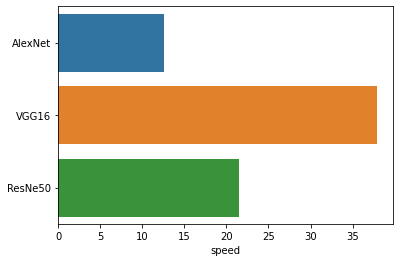

In [60]:
m_names = ["AlexNet", "VGG16", "ResNe50"]

sns.barplot(x=df.speed, y=m_names)

<AxesSubplot:xlabel='memory'>

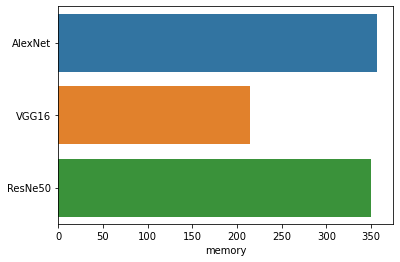

In [61]:
sns.barplot(x=df.memory, y=m_names)

<AxesSubplot:ylabel='top1_acc'>

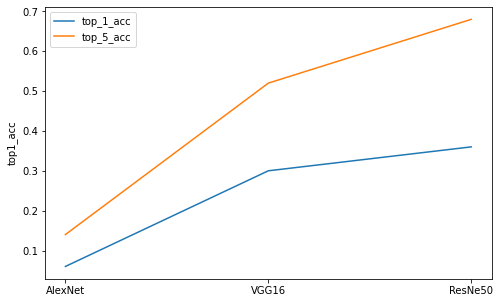

In [66]:
plt.figure(figsize=(8, 5))
sns.lineplot(df.top1_acc, label="top_1_acc")
sns.lineplot(df.top5_acc, label="top_5_acc")